In [90]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D


In [91]:
df = pd.read_csv('/content/StudentsPerformance.csv')

In [92]:

df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_", regex=False)
      .str.replace("-", "_", regex=False)
)

from typing import Iterable

def pick(df_cols: Iterable[str], *candidates: str) -> str:
    """
    Return the first candidate that exists in df_cols.
    Raises KeyError if none are found.
    Accepts df_cols as an Index, list, or any iterable of strings.
    """
    df_cols = list(df_cols)
    cols_set = set(df_cols)
    for c in candidates:
        if c in cols_set:
            return c
    raise KeyError(f"None of {candidates} found in columns: {list(df_cols)}")

math_col    = pick(df.columns, "math_score", "maths_score", "maths", "math")
reading_col = pick(df.columns, "reading_score", "reading")
writing_col = pick(df.columns, "writing_score", "writing")
gender_col  = pick(df.columns, "gender", "sex")
lunch_col   = pick(df.columns, "lunch", "lunch_type")
test_col    = pick(df.columns, "test_preparation_course", "test_prep", "test_prep_course")


In [93]:
scores = [math_col, reading_col, writing_col]
df[scores] = df[scores].apply(pd.to_numeric, errors="coerce")
grp = df.groupby([gender_col, lunch_col, test_col])
group_medians = grp[scores].transform("median")
df[scores] = df[scores].fillna(group_medians).fillna(df[scores].median())

cleaned_path = os.path.join('/content', "StudentsPerformance_cleaned.csv")
df.to_csv(cleaned_path, index=False)

print(f"Cleaned dataset saved to: {cleaned_path}")


Cleaned dataset saved to: /content/StudentsPerformance_cleaned.csv


In [94]:

_canvas_px = (800, 600)
_ref_dpi = 100

FIG_W, FIG_H = [px / _ref_dpi for px in _canvas_px]  # result in inches

DPI_SAVE = 300


result_dir = os.path.join('/content', 'question_2', 'Result')
os.makedirs(result_dir, exist_ok=True)


In [95]:
os.makedirs(result_dir, exist_ok=True)

def _save_and_close(fname):
    """Tighten layout, save to result_dir with DPI_SAVE, show and then close figure."""
    path = os.path.join(result_dir, fname)
    plt.tight_layout()
    plt.savefig(path, dpi=DPI_SAVE)
    plt.show()
    plt.close()


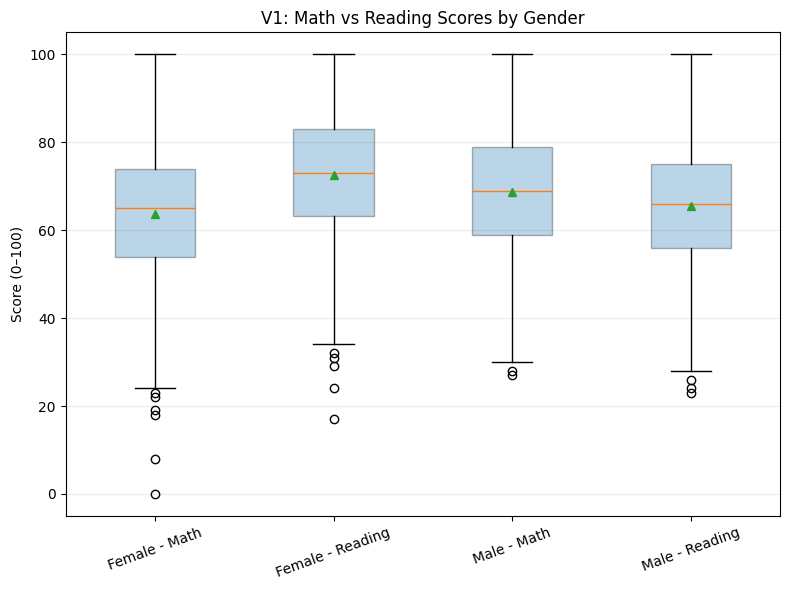

In [96]:
plt.figure(figsize=(FIG_W, FIG_H))
genders = df[gender_col].dropna().unique().tolist()
data_v1 = []
labels_v1 = []

for g in genders:
    sub = df.loc[df[gender_col] == g]
    # collect arrays (dropna to avoid empty points)
    data_v1.append(sub[math_col].dropna().values)
    data_v1.append(sub[reading_col].dropna().values)
    labels_v1.append(f"{g.title()} - Math")
    labels_v1.append(f"{g.title()} - Reading")

bp = plt.boxplot(data_v1, showmeans=True, patch_artist=True)
# set semi-transparent boxes
for b in bp["boxes"]:
    b.set_alpha(0.3)

# set tick labels explicitly to avoid Matplotlib deprecation warning
plt.xticks(ticks=np.arange(1, len(labels_v1) + 1), labels=labels_v1, rotation=20)

plt.ylabel("Score (0–100)")
plt.title("V1: Math vs Reading Scores by Gender")
plt.grid(axis="y", alpha=0.25)
_save_and_close("V1_gender_boxplots.png")


/tmp/ipython-input-813170741.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=test_col, y=math_col, data=df, palette="Set2", showmeans=True)


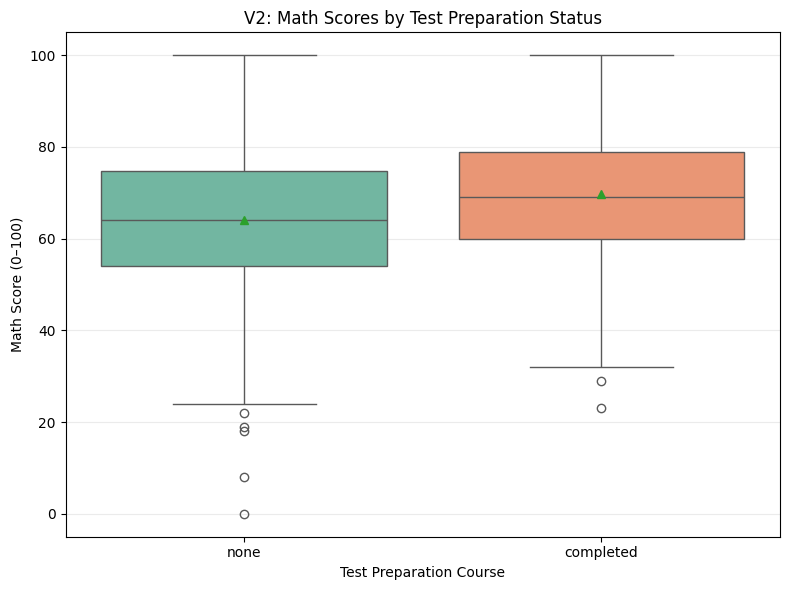

In [97]:
plt.figure(figsize=(FIG_W, FIG_H))
sns.boxplot(x=test_col, y=math_col, data=df, palette="Set2", showmeans=True)
plt.ylabel("Math Score (0–100)")
plt.xlabel("Test Preparation Course")
plt.title("V2: Math Scores by Test Preparation Status")
plt.grid(axis="y", alpha=0.25)
_save_and_close("V2_test_prep_math.png")

/tmp/ipython-input-509979711.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lunch_col, y='overall_avg', data=avg_by_lunch, palette="Set3")


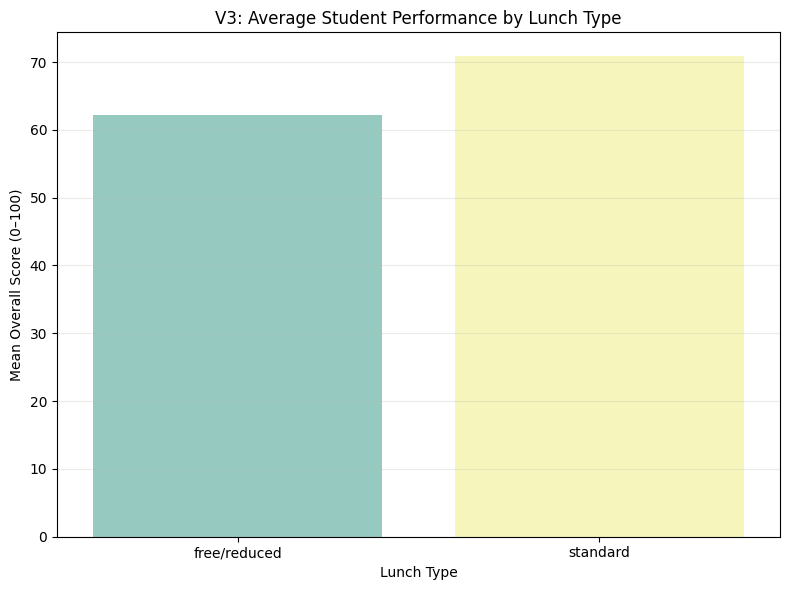

In [98]:
if 'overall_avg' not in df.columns:
    df['overall_avg'] = df[scores].mean(axis=1)

avg_by_lunch = df.groupby(lunch_col)['overall_avg'].mean().reset_index()
plt.figure(figsize=(FIG_W, FIG_H))
sns.barplot(x=lunch_col, y='overall_avg', data=avg_by_lunch, palette="Set3")
plt.ylabel("Mean Overall Score (0–100)")
plt.xlabel("Lunch Type")
plt.title("V3: Average Student Performance by Lunch Type")
plt.grid(axis="y", alpha=0.25)
_save_and_close("V3_lunch_avg.png")

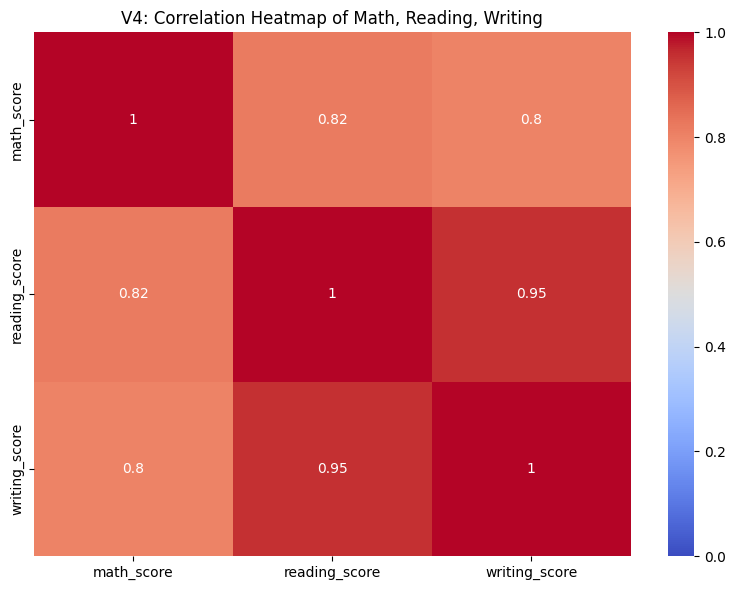

In [99]:
plt.figure(figsize=(FIG_W, FIG_H))
corr = df[scores].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("V4: Correlation Heatmap of Math, Reading, Writing")
_save_and_close("V4_subject_correlation.png")

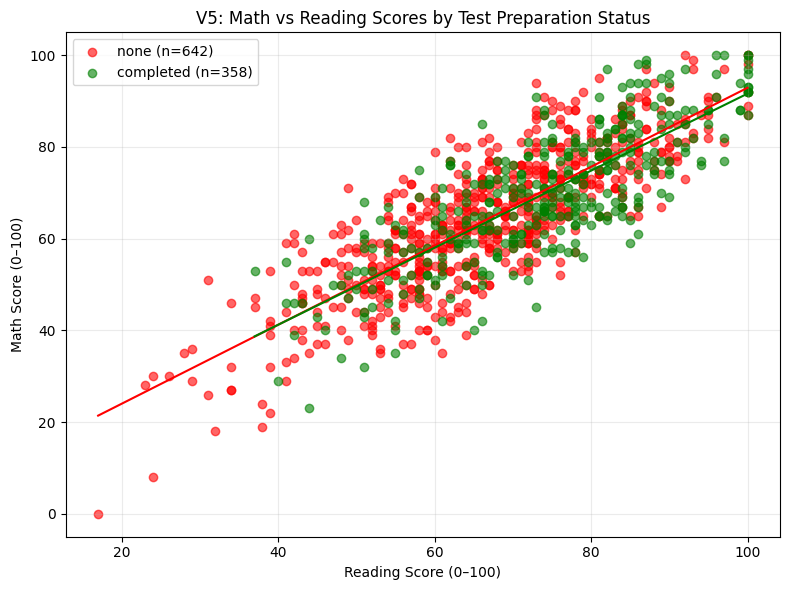

In [100]:
plt.figure(figsize=(FIG_W, FIG_H))
colors = {'completed': 'green', 'none': 'red'}

for status in df[test_col].dropna().unique():
    sub = df.loc[df[test_col] == status]
    x = sub[reading_col].dropna()
    y = sub[math_col].dropna()
    color = colors.get(status, None)
    plt.scatter(x, y, label=f"{status} (n={len(sub)})", color=color, alpha=0.6)

    if len(x) >= 2 and len(y) >= 2:
        try:
            m, b = np.polyfit(x, y, 1)
            xs = np.linspace(x.min(), x.max(), 100)
            plt.plot(xs, m * xs + b, color=color)
        except Exception:
            pass

plt.xlabel("Reading Score (0–100)")
plt.ylabel("Math Score (0–100)")
plt.title("V5: Math vs Reading Scores by Test Preparation Status")
plt.legend()
plt.grid(alpha=0.25)
_save_and_close("V5_math_reading_trend.png")